In [1]:
import os
import sys
import pandas as pd

ROOT_DIR = os.path.abspath("..")
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

DATA_DIR = os.path.join(ROOT_DIR, "data")
PROCESSED_DIR = os.path.join(DATA_DIR, "processed")

# Files from previous steps
RETURNS_CSV = os.path.join(PROCESSED_DIR, "prices_with_daily_returns.csv")
SENTIMENT_CSV = os.path.join(PROCESSED_DIR, "news_price_aligned_with_sentiment.csv")

from scripts.correlation_utils import (
    aggregate_daily_sentiment,
    merge_returns_and_sentiment,
    compute_correlations,
)


In [2]:
# Load prices with returns
returns_df = pd.read_csv(RETURNS_CSV, parse_dates=["Date"])

print("Prices + daily returns sample:")
display(returns_df.head())
print("Columns:", returns_df.columns.tolist())

# Load news with article-level sentiment
news_sent_df = pd.read_csv(SENTIMENT_CSV, parse_dates=["Date"])

print("\nNews + sentiment sample:")
display(news_sent_df.head())
print("Columns:", news_sent_df.columns.tolist())


Prices + daily returns sample:


,Date,Ticker,Close,High,Low,Open,Volume,DailyReturn
0,2009-01-02,AAPL,2.721686,2.730385,2.554037,2.575630,746015200,NaN
1,2009-01-05,AAPL,2.836553,2.884539,2.780469,2.794266,1181608400,0.042204
2,2009-01-06,AAPL,2.789767,2.914229,2.770872,2.877641,1289310400,-0.016494
3,2009-01-07,AAPL,2.729484,2.774170,2.706990,2.753477,753048800,-0.021609
4,2009-01-08,AAPL,2.780169,2.793666,2.700393,2.712090,673500800,0.018570


Columns: ['Date', 'Ticker', 'Close', 'High', 'Low', 'Open', 'Volume', 'DailyReturn']

News + sentiment sample:


,Date,stock,Unnamed: 0,headline,url,publisher,ClosePrice,sentiment_polarity,sentiment_subjectivity,sentiment_label
0,2020-06-10,AAPL,7120,Tech Stocks And FAANGS Strong Again To Start D...,https://www.benzinga.com/government/20/06/1622...,JJ Kinahan,85.566071,0.433333,0.733333,positive
1,2020-06-10,AAPL,7121,10 Biggest Price Target Changes For Wednesday,https://www.benzinga.com/analyst-ratings/price...,Lisa Levin,85.566071,0.000000,0.000000,neutral
2,2020-06-10,AAPL,7122,"Benzinga Pro's Top 5 Stocks To Watch For Wed.,...",https://www.benzinga.com/short-sellers/20/06/1...,Benzinga Newsdesk,85.566071,0.500000,0.500000,positive
3,2020-06-10,AAPL,7123,"Deutsche Bank Maintains Buy on Apple, Raises P...",https://www.benzinga.com/news/20/06/16219873/d...,Benzinga Newsdesk,85.566071,0.000000,0.000000,neutral
4,2020-06-10,AAPL,7124,Apple To Let Users Trade In Their Mac Computer...,https://www.benzinga.com/news/20/06/16218697/a...,Neer Varshney,85.566071,0.000000,0.000000,neutral


Columns: ['Date', 'stock', 'Unnamed: 0', 'headline', 'url', 'publisher', 'ClosePrice', 'sentiment_polarity', 'sentiment_subjectivity', 'sentiment_label']


In [3]:
# Optional: standardize ticker column to 'Ticker' in both
if "stock" in returns_df.columns:
    returns_df.rename(columns={"stock": "Ticker"}, inplace=True)

if "stock" in news_sent_df.columns:
    news_sent_df.rename(columns={"stock": "Ticker"}, inplace=True)


In [4]:
daily_sent = aggregate_daily_sentiment(
    news_sent_df,
    date_col="Date",
    ticker_col="Ticker",
    sentiment_col="sentiment_polarity",   # change if you named it differently
    agg_col_name="DailySentiment",
)

print("Daily sentiment sample:")
display(daily_sent.head())


Daily sentiment sample:


,Ticker,Date,DailySentiment,ArticleCount
0,AAPL,2020-03-09,-0.155556,3
1,AAPL,2020-03-10,0.021708,8
2,AAPL,2020-03-11,0.018624,14
3,AAPL,2020-03-12,-0.083048,5
4,AAPL,2020-03-13,0.069215,11


In [5]:
merged = merge_returns_and_sentiment(
    returns_df=returns_df,
    daily_sent_df=daily_sent,
    date_col="Date",
    ticker_col="Ticker",
    return_col="DailyReturn",
    sent_col="DailySentiment",
    how="inner",  # keep only overlapping dates where we have both return & sentiment
)

print("Merged (returns + sentiment) sample:")
display(
    merged[["Ticker", "Date", "Close", "DailyReturn",
            "DailySentiment", "ArticleCount"]]
    .head(20)
)
print("Merged shape:", merged.shape)


Merged (returns + sentiment) sample:


,Ticker,Date,Close,DailyReturn,DailySentiment,ArticleCount
0,AAPL,2020-03-09,64.373756,-0.079092,-0.155556,3
1,AAPL,2020-03-10,69.010056,0.072022,0.021708,8
2,AAPL,2020-03-11,66.613319,-0.034730,0.018624,14
3,AAPL,2020-03-12,60.034924,-0.098755,-0.083048,5
4,AAPL,2020-03-13,67.227592,0.119808,0.069215,11
5,AAPL,2020-03-16,58.578964,-0.128647,0.011136,11
6,AAPL,2020-03-17,61.154701,0.043970,0.034673,12
7,AAPL,2020-03-18,59.657631,-0.024480,0.104091,4
8,AAPL,2020-03-19,59.200531,-0.007662,0.000000,2
9,AAPL,2020-03-20,55.442158,-0.063485,0.085417,2


Merged shape: (1796, 10)


In [6]:
corr_results = compute_correlations(
    merged_df=merged,
    ticker_col="Ticker",
    return_col="DailyReturn",
    sent_col="DailySentiment",
)

overall_corr = corr_results["overall_corr"]
per_ticker_corr = corr_results["per_ticker"]

print(f"Overall Pearson correlation between DailySentiment and DailyReturn: {overall_corr:.4f}")

print("\nPer-ticker correlations:")
display(per_ticker_corr)


Overall Pearson correlation between DailySentiment and DailyReturn: 0.0911

Per-ticker correlations:


,Ticker,corr,n
1,AMZN,-0.029749,28
2,GOOG,0.056820,352
4,TSLA,0.082690,230
3,NVDA,0.103473,1125
0,AAPL,0.158145,61


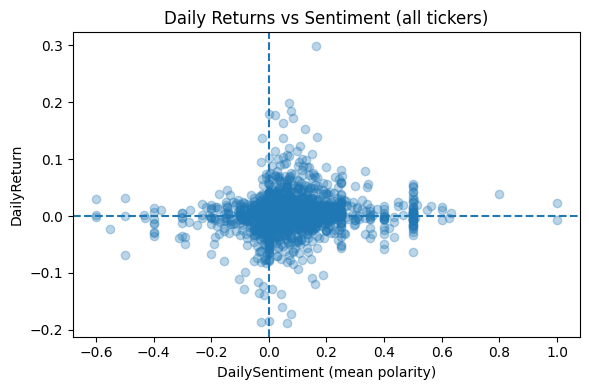

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.scatter(merged["DailySentiment"], merged["DailyReturn"], alpha=0.3)
plt.axhline(0, linestyle="--")
plt.axvline(0, linestyle="--")
plt.xlabel("DailySentiment (mean polarity)")
plt.ylabel("DailyReturn")
plt.title("Daily Returns vs Sentiment (all tickers)")
plt.tight_layout()
plt.show()


# 📊 Correlation Analysis: Daily Sentiment vs Daily Stock Returns

## **1. Overall Correlation**

The overall Pearson correlation between **DailySentiment** and **DailyReturn** is:

0.0911

This indicates a **very weak positive linear relationship**.

- When daily sentiment becomes slightly more positive, stock returns also tend to rise *slightly*.
- However, the relationship is **small and not strong enough** to serve as a reliable standalone predictor of daily price movements.

This is expected in financial markets where short-term returns are influenced by many factors (macro news, earnings, liquidity, volatility), not sentiment alone.

---

## **2. Per-Ticker Correlations**

| Ticker | Correlation | N (Days) | Interpretation |
|--------|-------------|----------|----------------|
| **AAPL** | **0.158** | 61 | Weak-to-moderate positive correlation. Apple reacts more strongly to sentiment than other tickers. |
| **NVDA** | 0.103 | 1125 | Very weak positive correlation; sentiment has a small influence. |
| **TSLA** | 0.082 | 230 | Extremely weak correlation; noisy relationship. |
| **GOOG** | 0.056 | 352 | Almost no linear relationship. |
| **AMZN** | -0.029 | 28 | Slight negative correlation but sample size is too small to be meaningful. |

### 🔍 **Interpretation**

- **AAPL** shows the strongest sentiment–return connection.
- **NVDA**, **TSLA**, and **GOOG** have very weak positive correlations.
- **AMZN** has nearly zero correlation due to low sample size.

Overall, **sentiment has limited daily predictive power**, with only small effects visible in certain tickers.

---

## **3. Scatter Plot Interpretation**

The scatter plot of **DailySentiment vs. DailyReturn** reveals:

- Returns cluster heavily around **0%**, normal for daily stock data.
- Sentiment mostly hovers near **neutral** (0.0 polarity).
- No clear upward or downward slope → **confirms weak correlation**.
- The spread is wide, indicating high noise and variability.

This visual reinforces that **sentiment alone cannot explain most day-to-day price changes.**

---

## **4. Executive Summary**

> **Daily news sentiment shows only a weak positive correlation with daily stock returns (r ≈ 0.09).**  
> This means sentiment provides limited predictive power for short-term market movements.

> **Among all tickers, Apple (AAPL) shows the strongest relationship (r ≈ 0.16),** suggesting that its price responds more consistently to sentiment shifts.

> **Other stocks like TSLA, NVDA, and GOOG show very weak correlations**, indicating that daily sentiment has minimal impact on their short-term returns.

> This outcome matches financial theory: **stock prices are driven by many variables**, and sentiment contributes only a small part of the movement on a daily basis.

---

